# Clustering

In this notebook we do the three types of clustering discussed 

In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

In [2]:
DATASET_DIR = "dataset" + os.sep

In [3]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v2.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v2.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v2.csv", parse_dates=["date"])

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589771 entries, 0 to 589770
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589771 non-null  object        
 1   points             589771 non-null  int64         
 2   length             589771 non-null  float64       
 3   profile            475349 non-null  float64       
 4   startlist_quality  589771 non-null  int64         
 5   date               589771 non-null  datetime64[ns]
 6   position           589771 non-null  int64         
 7   cyclist            589771 non-null  object        
 8   cyclist_age        589658 non-null  float64       
 9   delta              589771 non-null  int64         
 10  race               589771 non-null  object        
 11  year               589771 non-null  int64         
 12  stage              589771 non-null  object        
 13  birth_year         589724 non-null  float64 

In [5]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6095 non-null   object 
 1   name         6095 non-null   object 
 2   birth_year   6084 non-null   float64
 3   height       3134 non-null   float64
 4   nationality  6095 non-null   object 
 5   BMI          3134 non-null   float64
dtypes: float64(3), object(3)
memory usage: 285.8+ KB


In [6]:
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _url               5281 non-null   object        
 1   stage              5281 non-null   object        
 2   race               5281 non-null   object        
 3   date               5281 non-null   datetime64[ns]
 4   points             5281 non-null   int64         
 5   length             5281 non-null   int64         
 6   profile            3326 non-null   float64       
 7   startlist_quality  5281 non-null   int64         
 8   year               5281 non-null   int64         
 9   season             5281 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 412.7+ KB


In [7]:
# unique attributes are useless for clustering
# Remove also redundant attributes and dates

merged_df.drop(columns=['_url', 'date', 'height'], inplace=True)
cyclist_df.drop(columns=['name', '_url', 'height'], inplace=True)
stages_df.drop(columns=['_url', 'date'], inplace=True)

# Drop rows containing nan
races_df = merged_df.dropna()
cyclist_df = cyclist_df.dropna()
stages_df = stages_df.dropna()

In [9]:
races_df.info()
cyclist_df.info()
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402686 entries, 0 to 589770
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             402686 non-null  int64  
 1   length             402686 non-null  float64
 2   profile            402686 non-null  float64
 3   startlist_quality  402686 non-null  int64  
 4   position           402686 non-null  int64  
 5   cyclist            402686 non-null  object 
 6   cyclist_age        402686 non-null  float64
 7   delta              402686 non-null  int64  
 8   race               402686 non-null  object 
 9   year               402686 non-null  int64  
 10  stage              402686 non-null  object 
 11  birth_year         402686 non-null  float64
 12  weight             402686 non-null  float64
 13  nationality        402686 non-null  object 
 14  season             402686 non-null  object 
dtypes: float64(5), int64(5), object(5)
memory usage: 49.2+ M

Let's define transform and inverse function for our dataset

In [67]:
def transform(df, categorical_cols, numerical_cols, samples=0):
    if samples != 0:
        df = df.sample(n=samples, random_state=1804)
    # Preprocess the data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
        ]
    )
    transformed_data = preprocessor.fit_transform(df)
    return transformed_data, preprocessor

def inverse_transformation(transformed_data, preprocessor, categorical_cols, numerical_cols):
    # Extract transformed numerical and categorical parts
    num_transformer = preprocessor.named_transformers_['num']
    cat_transformer = preprocessor.named_transformers_['cat']
    
    # Separate numerical and categorical data
    num_data = transformed_data[:, :len(numerical_cols)]
    cat_data = transformed_data[:, len(numerical_cols):]

    # Inverse the transformations
    inverse_num_data = num_transformer.inverse_transform(num_data)
    inverse_cat_data = cat_transformer.inverse_transform(cat_data)

    # Recombine columns
    return pd.DataFrame(
        np.hstack((inverse_num_data, inverse_cat_data)),
        columns=numerical_cols + categorical_cols
    )


## K-means

So first of all we are going to fine tune K. using the coso method with sse plot

In [20]:
def kmeans_explore(df, categorical_cols, numerical_cols, comps=0, max_k=40, random_state=1804):
    transformed_data = transform(df, categorical_cols, numerical_cols)[0]
    # Reduce dims if requested
    if comps != 0:
        pca = PCA(n_components=comps)
        transformed_data = pca.fit_transform(transformed_data)
        
    # Compute SSE for different cluster sizes
    sse = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=random_state)
        kmeans.fit(transformed_data)
        sse.append(kmeans.inertia_)
    
    # Plot SSE
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, sse, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.grid(True)
    plt.show()
    
    
def optimal_kmeans(df, categorical_cols, numerical_cols, n_clusters, fname):
    df = df.copy()
    transformed_data, preproc = transform(df, categorical_cols, numerical_cols)

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, random_state=1804)
    kmeans.fit(transformed_data)
    
    df['Cluster'] = kmeans.labels_
    df['Distance_to_Centroid'] = kmeans.transform(transformed_data).min(axis=1)

    # Inverse transform centroids for interpretability
    centroids_df = inverse_transformation(
        kmeans.cluster_centers_, preproc, categorical_cols, numerical_cols
    )
    centroids_df['Cluster'] = centroids_df.index

    df.to_csv(f"{fname}-kmeans-result.csv", index=False)
    centroids_df.to_csv(f"{fname}-kmeans_centroids.csv", index=False)

    return df, centroids_df, kmeans

Small tables we can make deep analysis

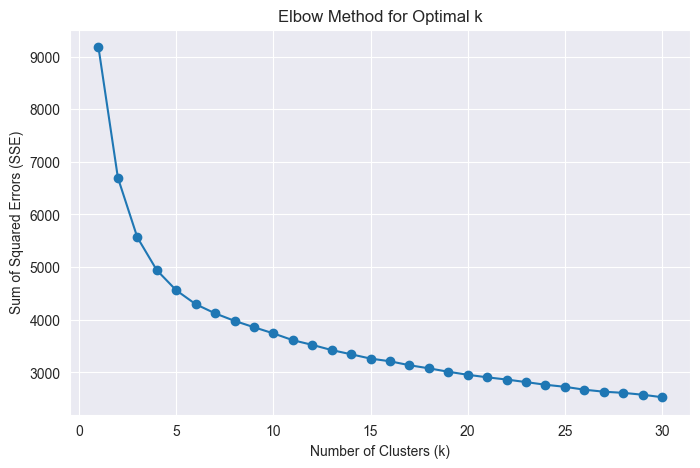

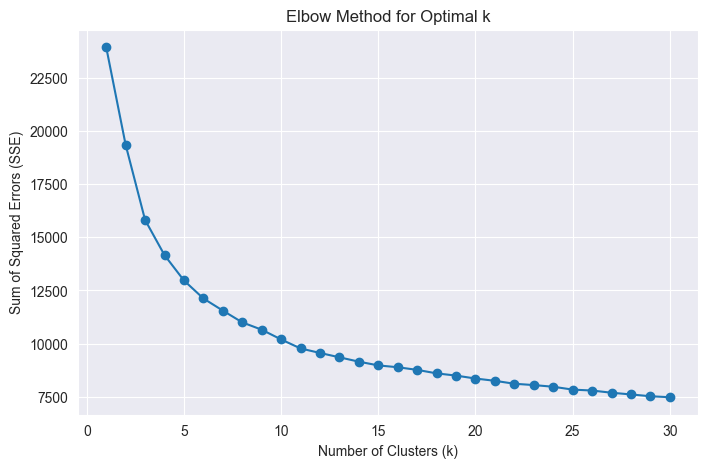

In [12]:
kmeans_explore(cyclist_df, ['nationality'], ['birth_year','BMI'])
kmeans_explore(stages_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'])

Big table require too much time without dim reduction. Also we can see the results are very similar 

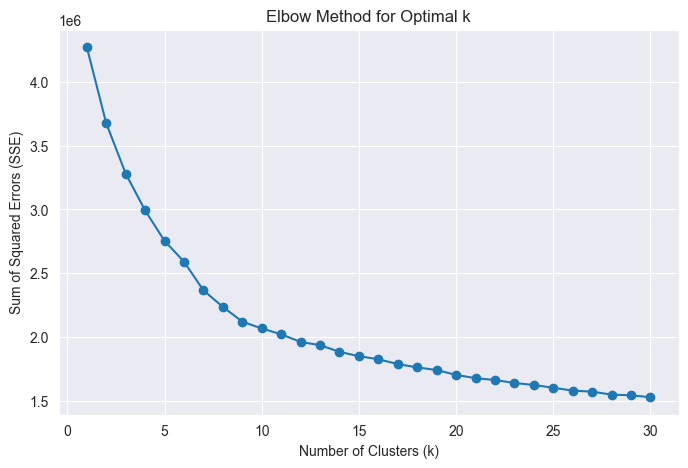

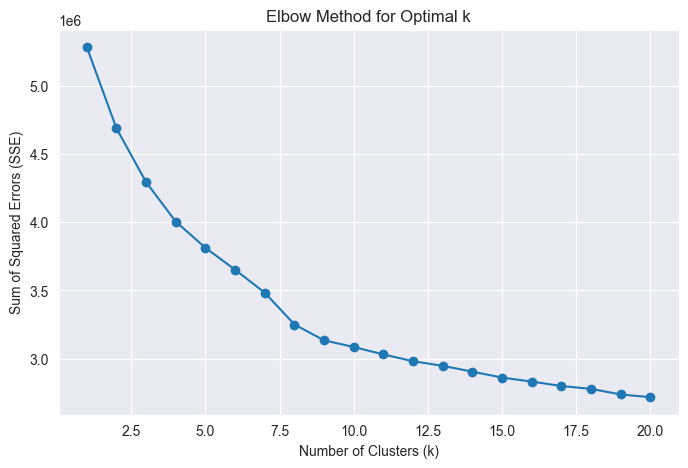

In [13]:

# With PCA
kmeans_explore(races_df, ['stage','race', 'profile', 'season', 'nationality', 'cyclist'], ['startlist_quality','year', 'points', 'length', 'birth_year', 'position', 'cyclist_age','delta'], comps=20, max_k=30)

# No reduction
kmeans_explore(races_df, ['stage','race', 'profile', 'season', 'nationality', 'cyclist'], ['startlist_quality','year', 'points', 'length', 'birth_year', 'position', 'cyclist_age','delta'], comps=0, max_k=20)

We get almost same results. Should we use cuda and make deep analysis??? I don't think

We can now get the results of the best hyppa paramitar

In [28]:
optimal_kmeans(cyclist_df, ['nationality'], ['birth_year','BMI'], 7, 'cyclists')
optimal_kmeans(stages_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'], 8, 'stages')
optimal_kmeans(races_df, ['stage','race', 'profile', 'season', 'nationality', 'cyclist'], ['startlist_quality','year', 'points', 'length', 'birth_year', 'position', 'cyclist_age','delta'], 8, 'merged')

(        points    length  profile  startlist_quality  position  \
 0          100  162000.0      1.0               1241         0   
 2          100  162000.0      1.0               1241         2   
 4          100  162000.0      1.0               1241         4   
 9          100  162000.0      1.0               1241         9   
 10         100  162000.0      1.0               1241        10   
 ...        ...       ...      ...                ...       ...   
 589766      80    8400.0      1.0                878       192   
 589767      80    8400.0      1.0                878       193   
 589768      80    8400.0      1.0                878       194   
 589769      80    8400.0      1.0                878       195   
 589770      80    8400.0      1.0                878       196   
 
                    cyclist  cyclist_age  delta            race  year    stage  \
 0               sean-kelly         22.0      0  tour-de-france  1978  stage-6   
 2           rene-bittinger   

## Hierarchical clustering

In [69]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

def hc(df, cat, num, color_threshold=10, truncate_mode='lastp', p=12, samples=0):
    # Linkage and distance metrics to test
    transformed_data = transform(df, cat, num, samples=samples)[0]
    
    linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid', 'median']
    distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev', 'minkowski']

    # Initialize the plot grid
    fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(20, 20))
    fig.tight_layout(pad=4.0)

    for i, method in enumerate(linkage_methods):
        for j, metric in enumerate(distance_metrics):
            try:
                # Compute pairwise distances and hierarchical linkage
                data_dist = pdist(transformed_data, metric=metric)
                data_link = linkage(data_dist, method=method)
                
                # Plot dendrogram
                dendrogram(
                    data_link, 
                    ax=axes[i, j], 
                    color_threshold=color_threshold, 
                    truncate_mode=truncate_mode, 
                    p=p, 
                    no_labels=True
                )
                axes[i, j].set_title(f'{method.capitalize()} - {metric.capitalize()}')
            except Exception as e:
                axes[i, j].set_title(f'{method.capitalize()} - {metric.capitalize()} (Failed)')
                print(f"Error with {method}-{metric}: {e}")
    
    plt.show()



let's run the algorithm on all table with all methods and metrics

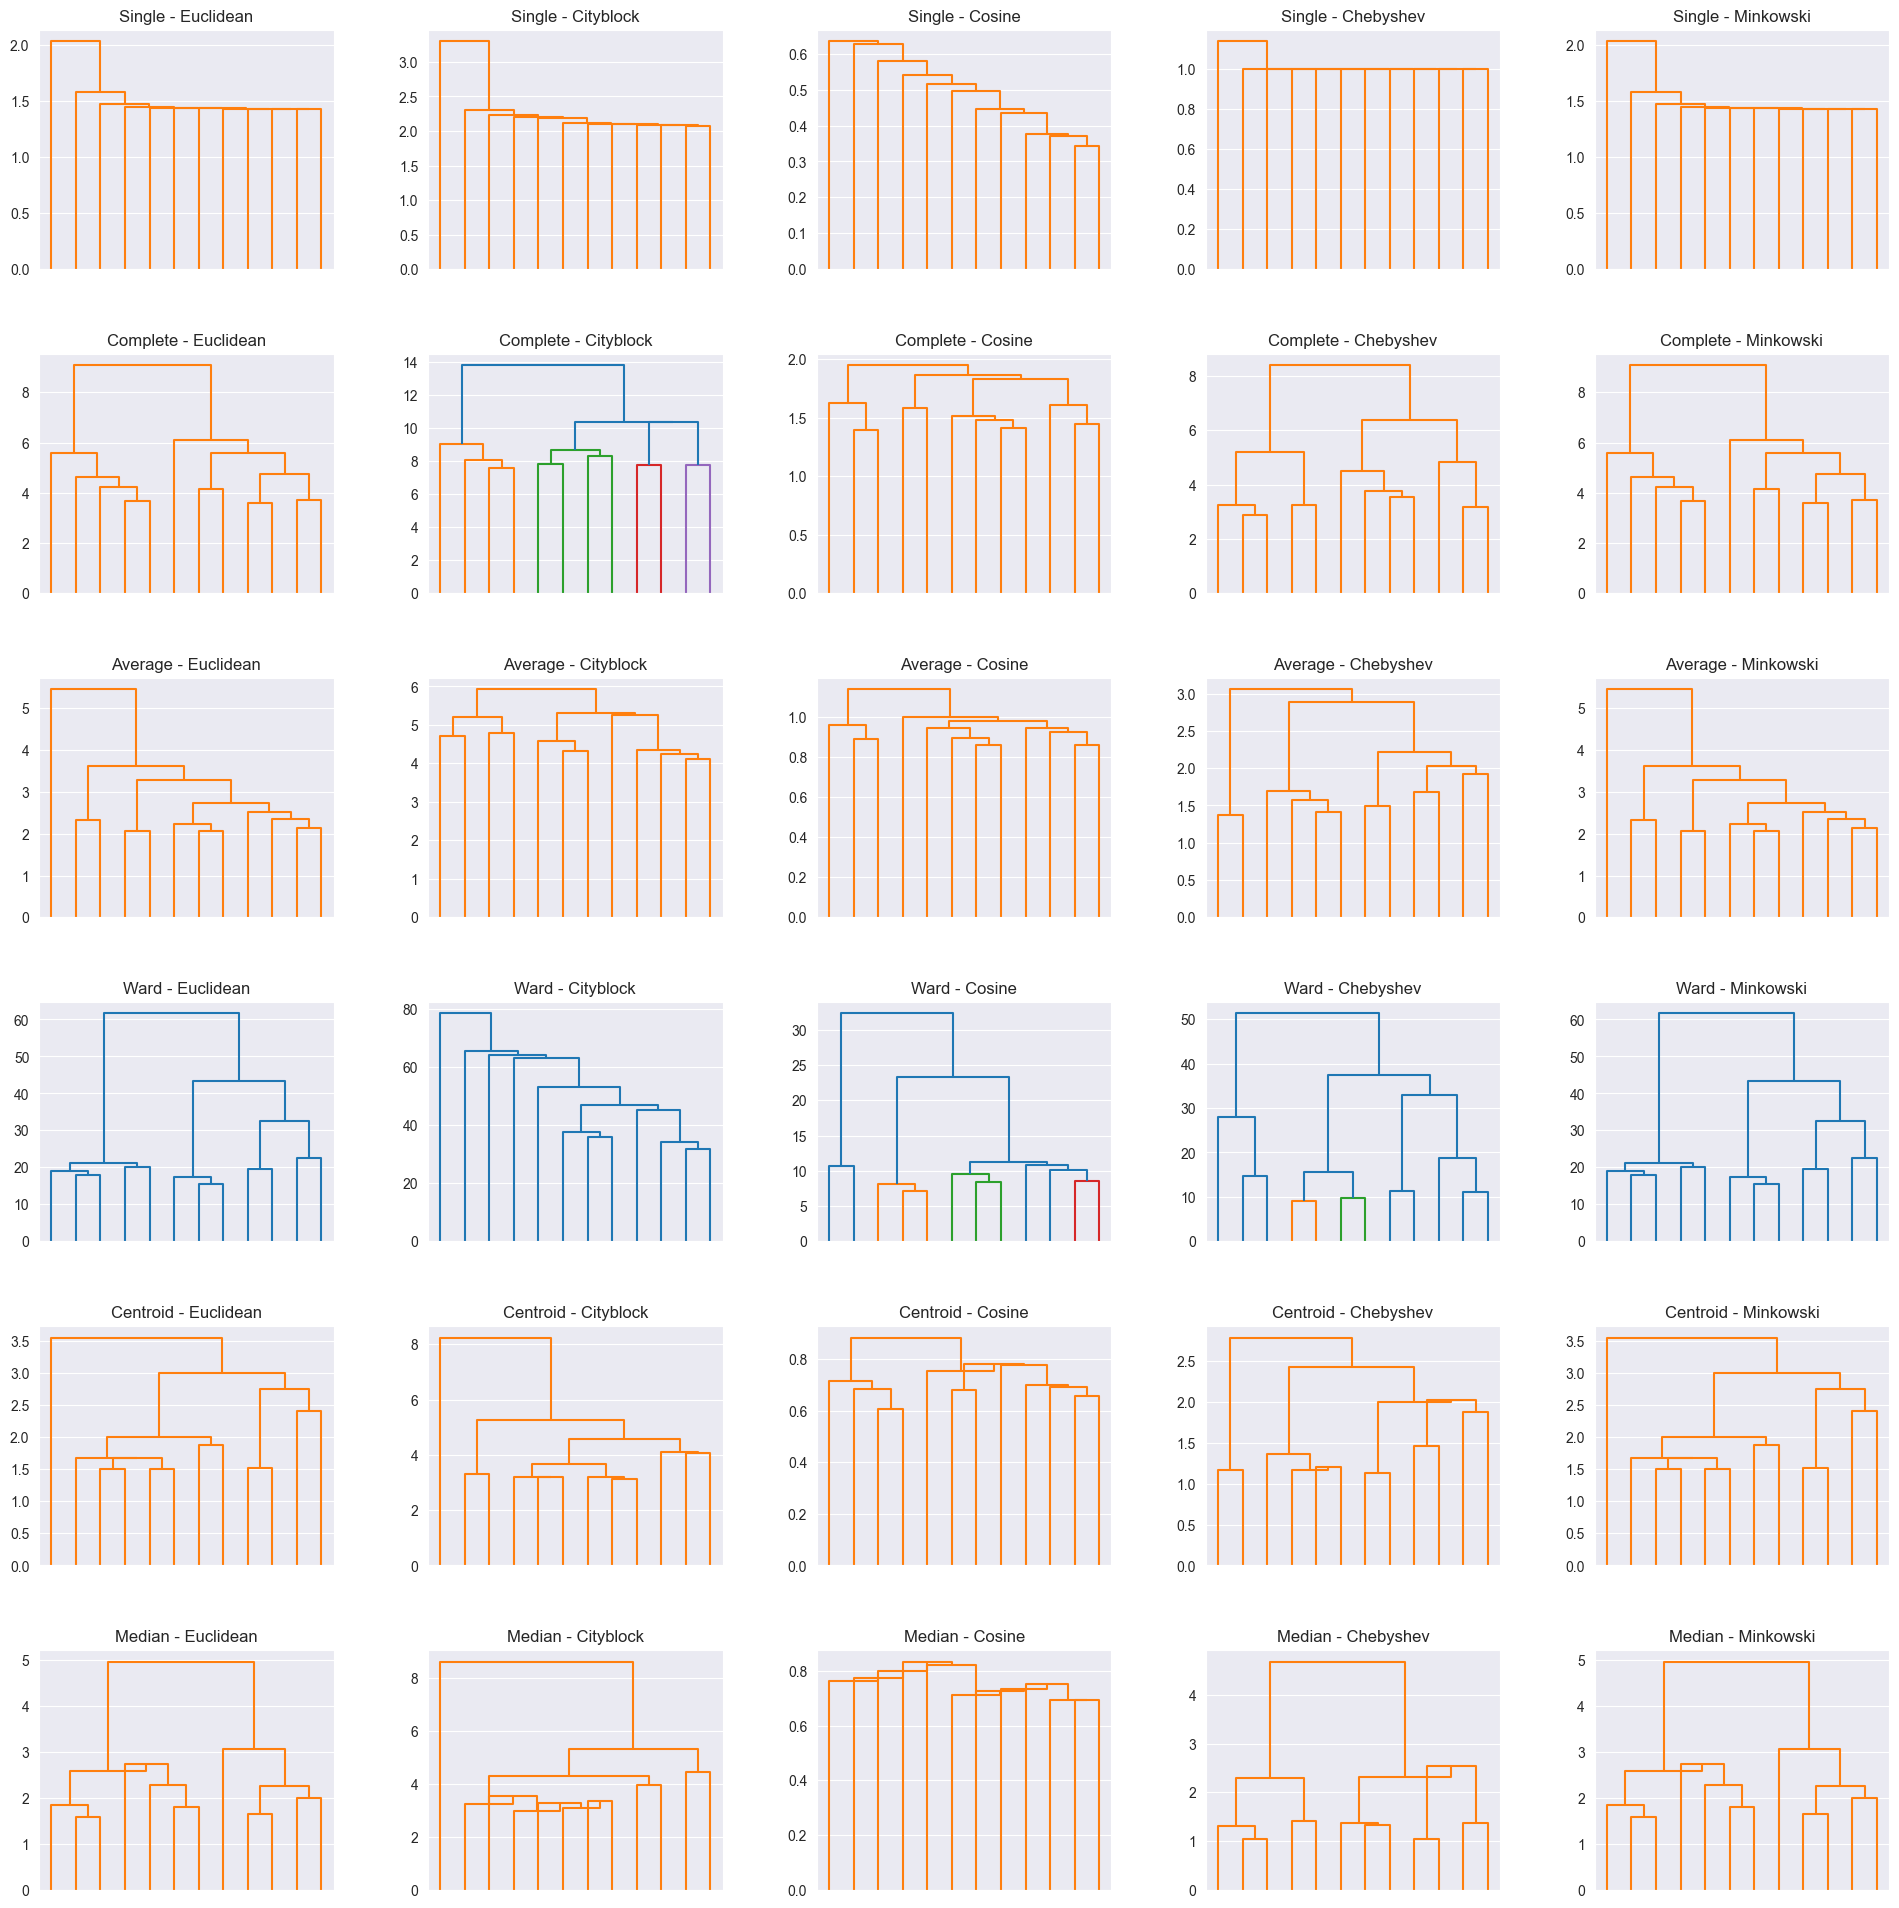

In [59]:
hc(cyclist_df, ['nationality'], ['birth_year','BMI'])

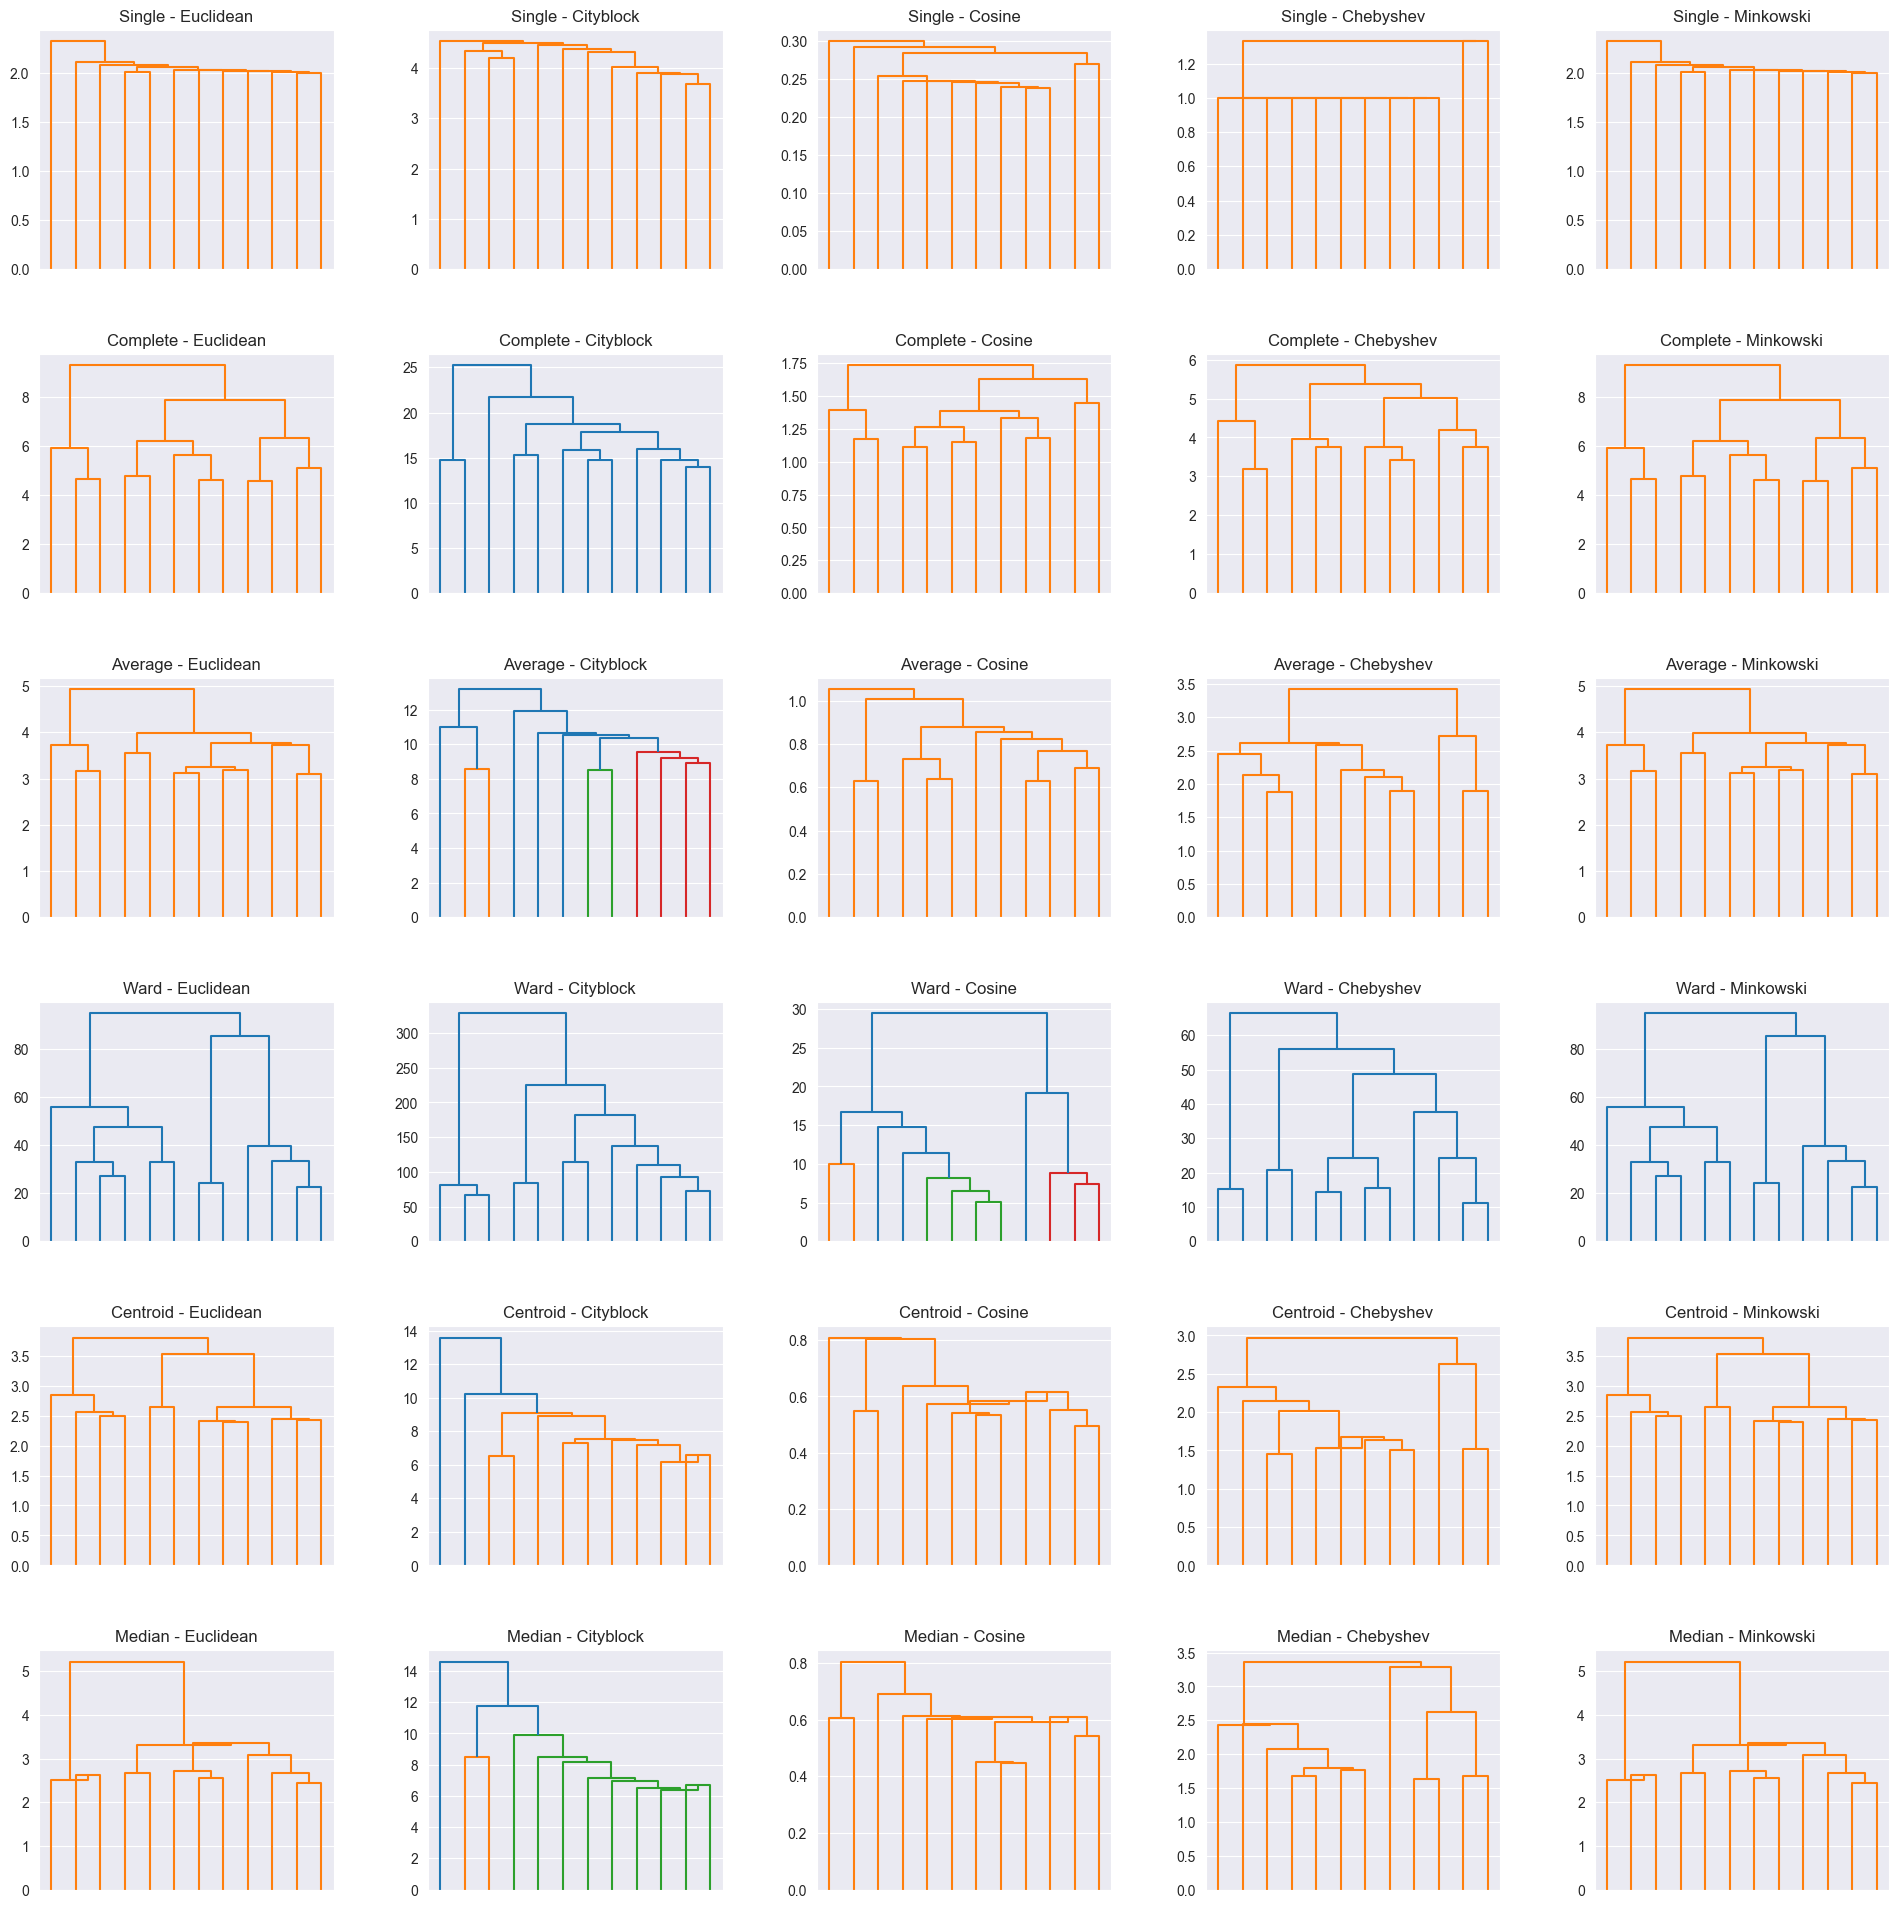

In [65]:
hc(stages_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'])

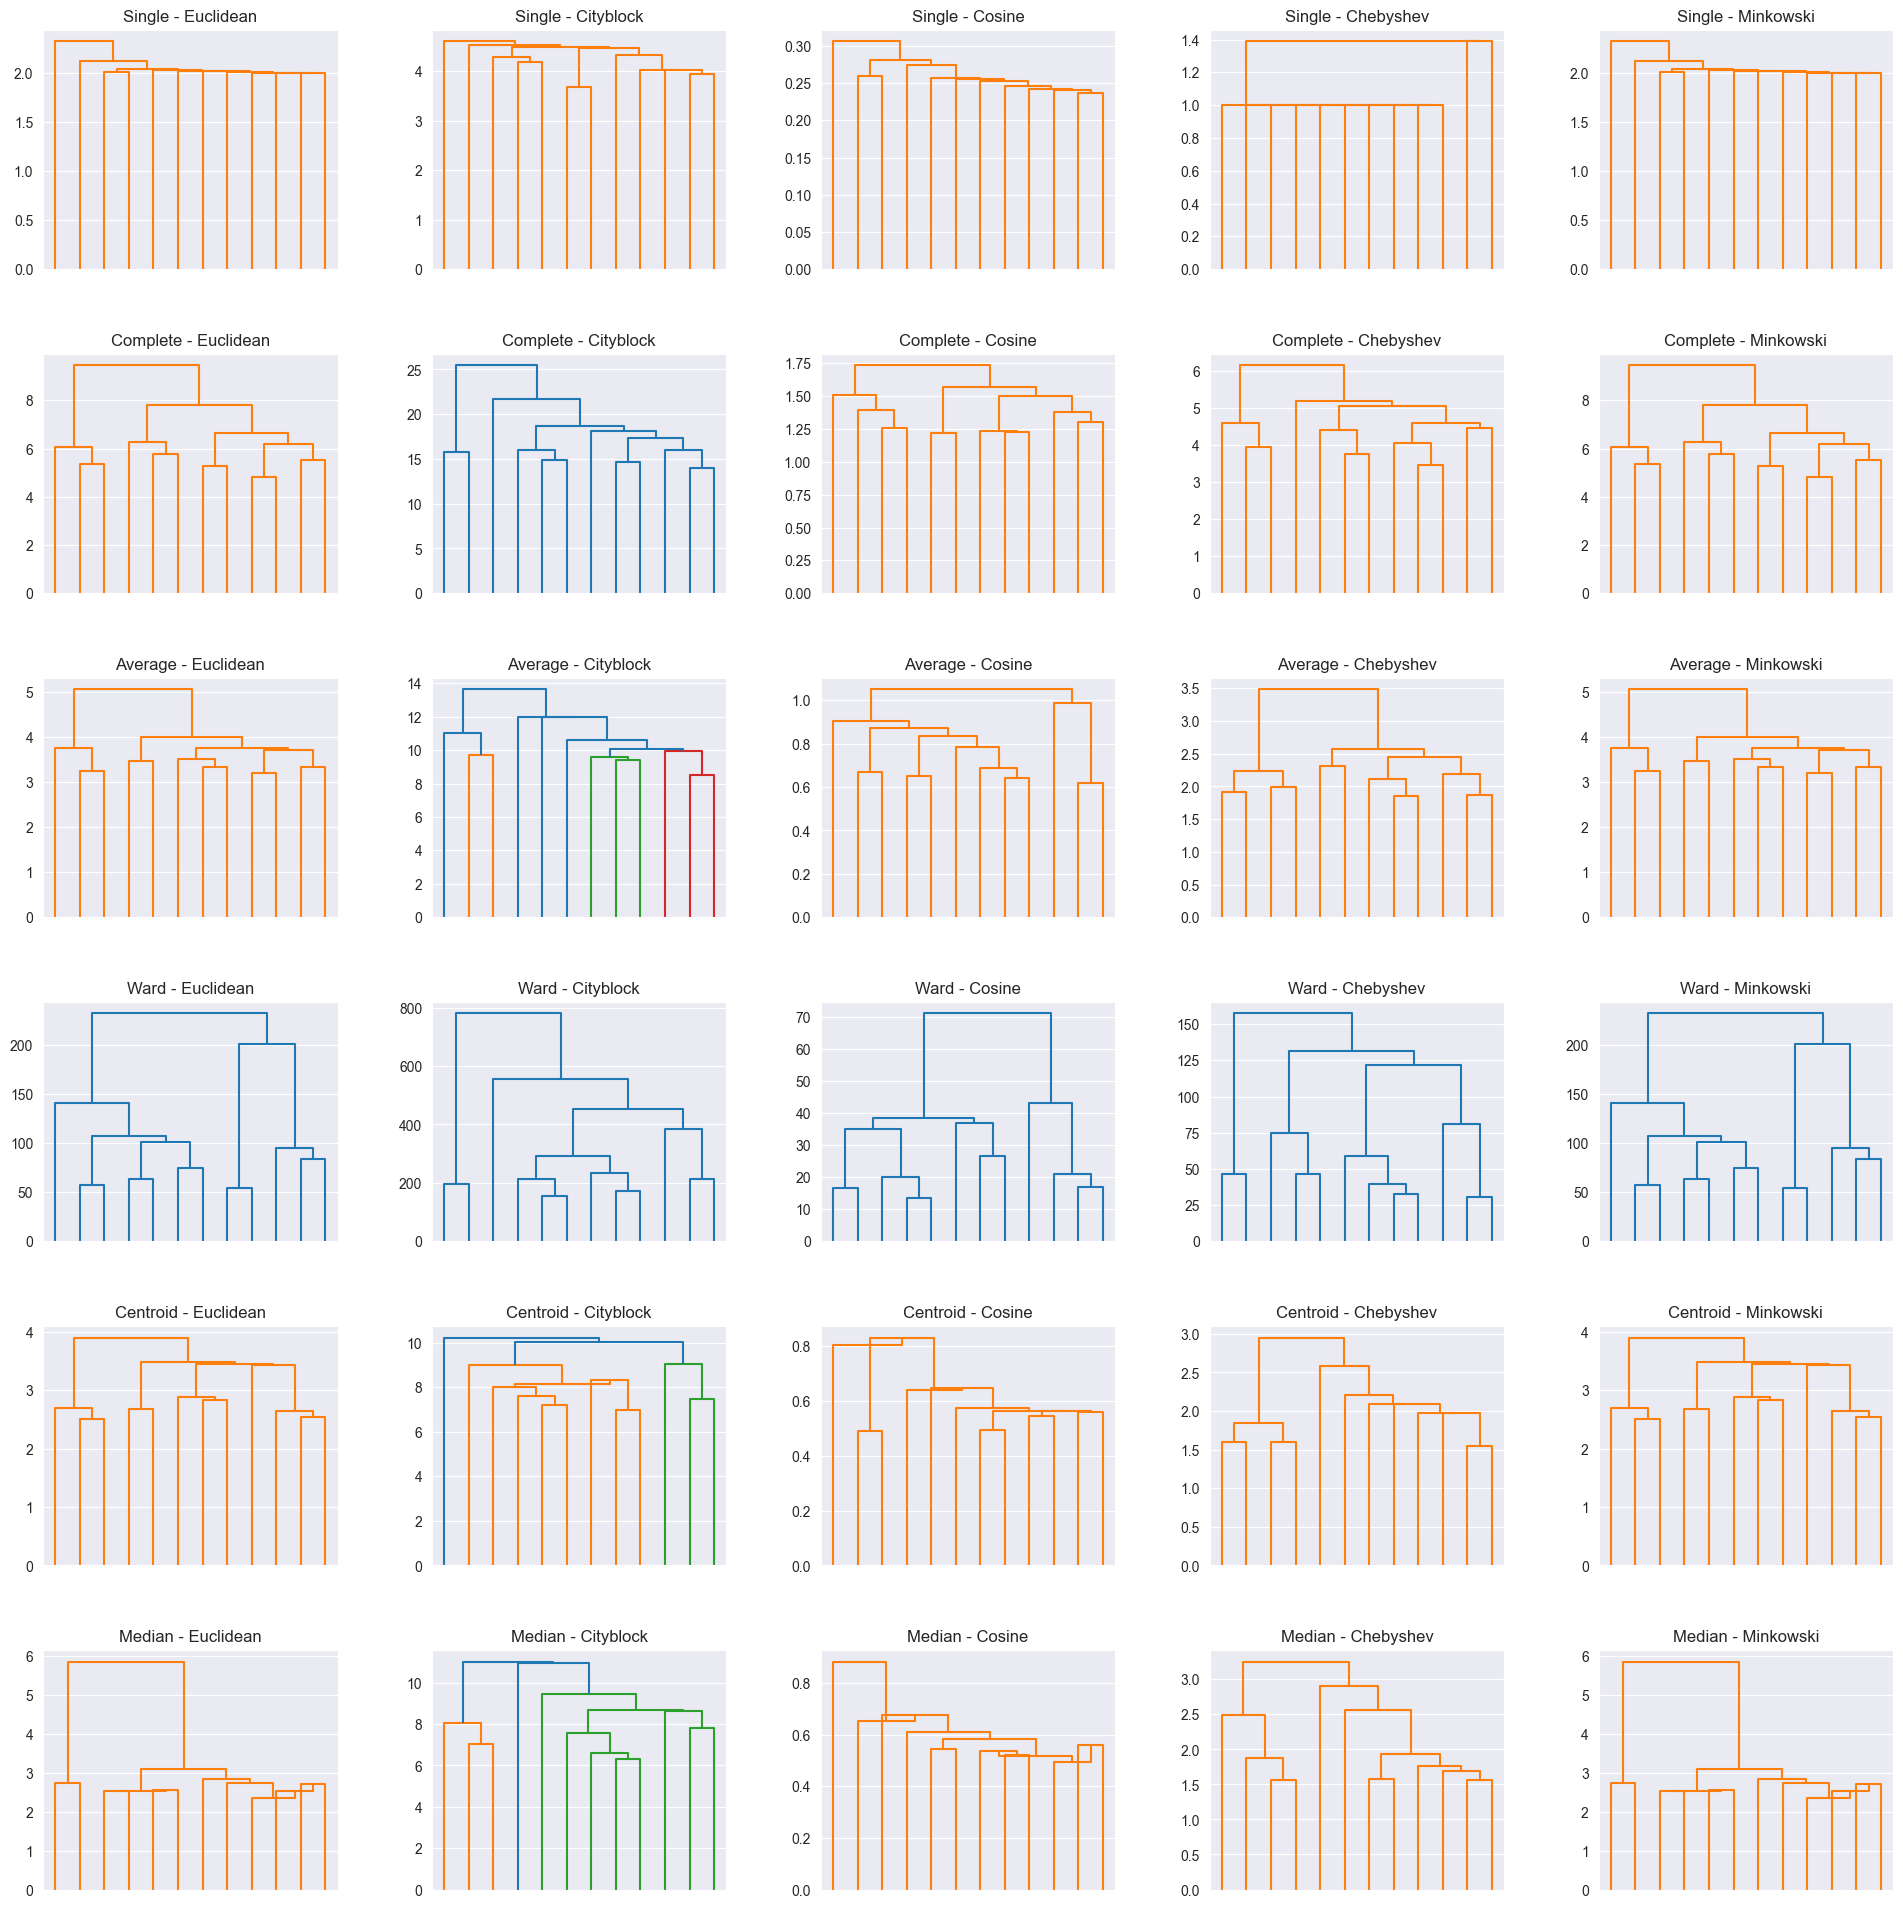

In [70]:
hc(merged_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'], samples=20000)

## DBscan

In [42]:
df = transform(cyclist_df, ['nationality'], ['birth_year','BMI'])
dist1 = pdist(df, 'euclidean') 
dist1 = squareform(dist1) #distance matrix given the vector dist
print(dist1.shape)

df = transform(stages_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'])
dist2 = pdist(df, 'euclidean') 
dist2 = squareform(dist2) #distance matrix given the vector dist
print(dist2.shape)

df = transform(merged_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length'], samples=20000)
dist3 = pdist(df, 'euclidean') 
dist3 = squareform(dist3) #distance matrix given the vector dist
print(dist3.shape)

dists = [dist1, dist2, dist3]

(3134, 3134)
(3326, 3326)
(20000, 20000)


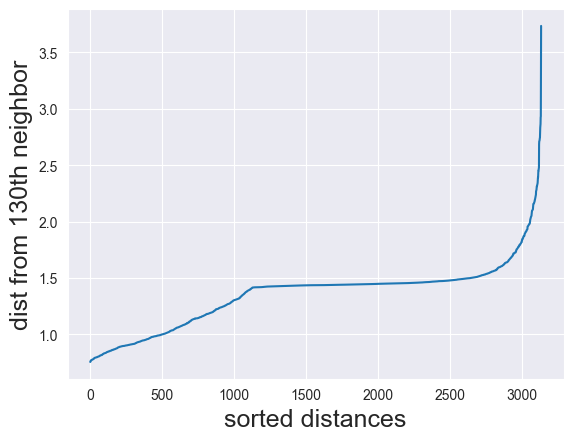

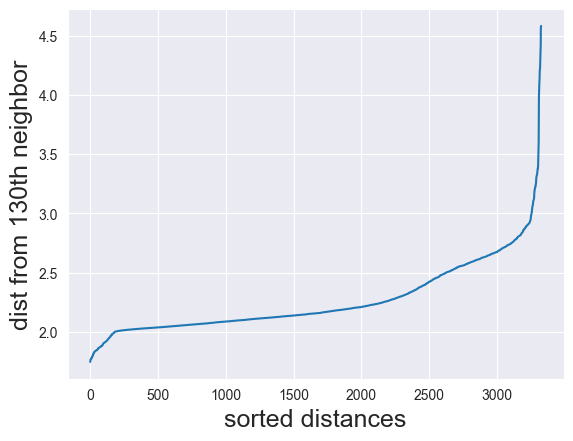

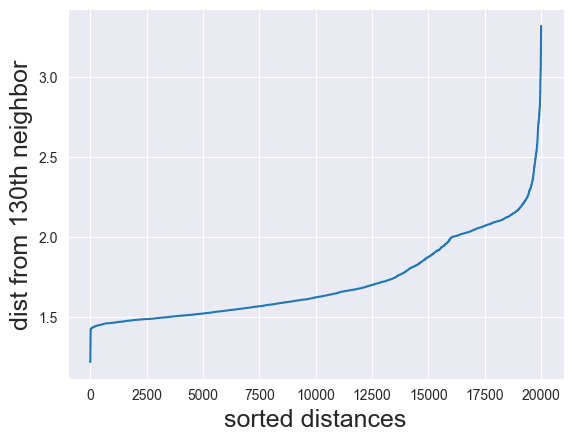

In [45]:
import numpy as np
import math

for dist in dists:
    k = 130
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

df = pd.DataFrame(transform(cyclist_df, ['nationality'], ['birth_year','BMI']))
dbscan = DBSCAN(eps=1.6, min_samples=df.shape[1] * 2)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(df)
df['Cluster'] = labels

df = pd.DataFrame(transform(stages_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length']))
dbscan = DBSCAN(eps=2.3, min_samples=df.shape[1] * 2)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(df)
df['Cluster'] = labels

df = pd.DataFrame(transform(merged_df, ['stage','race', 'profile', 'season'], ['startlist_quality','year', 'points', 'length']))
dbscan = DBSCAN(eps=1.6, min_samples=df.shape[1] * 2)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(df)
df['Cluster'] = labels

